# Introduction

In this notebook, we will use Prophet library to perform time series forecasting.

In [1]:
# ran the followinbg to install prophet:
# import sys
# !{sys.executable} -m pip install prophet

In [2]:
# !pip install --upgrade ipywidgets

In [7]:
#import necessary libraries
import numpy as np
import pandas as pd
from data_loader import load_names_from_web
from prophet import Prophet
import matplotlib.pyplot as plt

## Load Data

In [4]:
# Load data
dfraw = load_names_from_web()   # default category="both", hide_pre_1937=True

In [5]:
# add percentage column
state_year = dfraw.groupby(['state', 'year']).sum(numeric_only=True).reset_index()
df2 = pd.merge(dfraw, state_year, on=['state', 'year'], how='left', suffixes=('', '_agg'))
df2['perc'] = 100*df2['count']/df2['count_agg']
df2.drop(['count_agg'], axis=1, inplace=True)
df2.sample(5)

,state,year,name,M/F,count,perc
6440960,TX,1986,Sheryl,F,12,0.004317
6181744,SC,1990,Sidney,M,9,0.020313
5570634,OH,1981,Chandra,F,23,0.015042
4737901,NC,1987,Tamekia,F,5,0.006347
3868653,LA,1948,Perry,M,35,0.052880


In [6]:
# get the min and max years, to be used later
max_year = max(df2['year'])
min_year = min(df2['year'])

#Show example
min_year, max_year

(1937, 2022)

In [40]:
# note: alaska and hawaii data goes back to 1937 even though they were not states yet, per:
# df2[['state', 'year']].groupby('state').min()

## For now, look at US only, and focus on names that have been used *every* year

In [14]:
# how many names for US?
df_US = df2[df2['state'] == "US"]
print('count of US names: ', df_US[['name', 'M/F']].drop_duplicates().shape[0])

count of US names:  108772


In [15]:
# how many names in the US have been in the data for every year?
df_US_continuous = df_US.pivot_table(values='perc', index=['name', 'M/F'], columns='year').reset_index()
df_US_continuous = df_US_continuous.dropna(axis=0)
print('count of US names with no gaps in data: ', df_US_continuous.shape[0])

count of US names with no gaps in data:  2357


In [16]:
# put the df back into long format
df_US_continuous = pd.melt(df_US_continuous, 
                           id_vars=['name', 'M/F'], 
                           value_vars=[year for year in range(min_year, 1+max_year)],
                           var_name='year', 
                           value_name='perc')

,name,M/F,year,perc
0,Aaron,M,1937,0.021825
1,Abbie,F,1937,0.002441
2,Abby,F,1937,0.001173
3,Abe,M,1937,0.002957
4,Abel,M,1937,0.004271


In [17]:
df_US_continuous['ds'] = pd.to_datetime(df_US_continuous['year'], format='%Y')
df_US_continuous.head()

,name,M/F,year,perc,ds
0,Aaron,M,1937,0.021825,1937-01-01
1,Abbie,F,1937,0.002441,1937-01-01
2,Abby,F,1937,0.001173,1937-01-01
3,Abe,M,1937,0.002957,1937-01-01
4,Abel,M,1937,0.004271,1937-01-01


## pick some sample names, See how well prophet works for different forecast ranges. 

In [36]:
names = [('Jonathan', 'M'), ('Jordan', 'M'), ('Paul', 'M')]

In [37]:
# forecast_ranges = [1,5,10,20]
forecast_ranges = [5, 20]

17:03:06 - cmdstanpy - INFO - Chain [1] start processing
17:03:06 - cmdstanpy - INFO - Chain [1] done processing


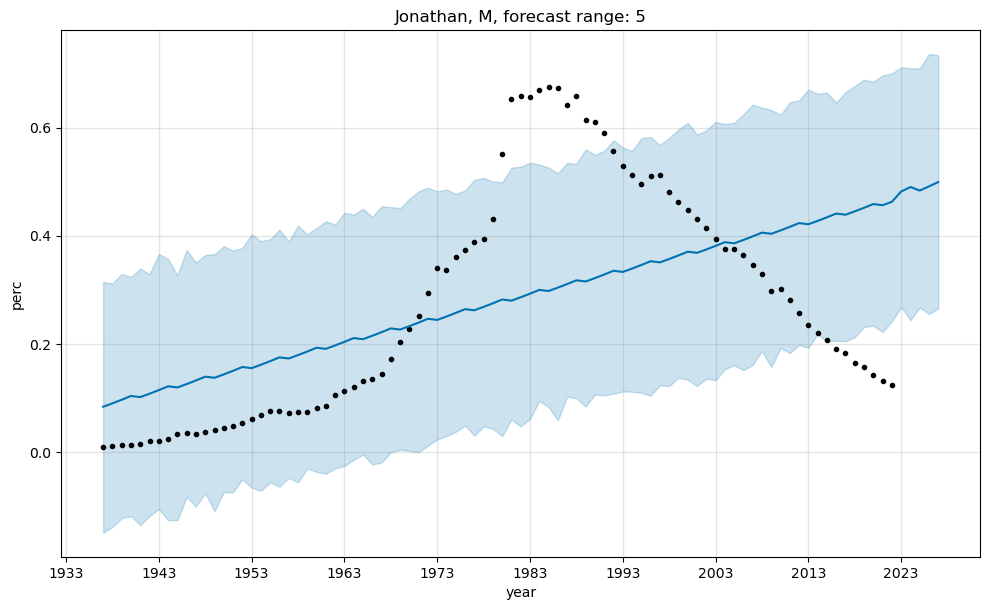

17:03:06 - cmdstanpy - INFO - Chain [1] start processing
17:03:06 - cmdstanpy - INFO - Chain [1] done processing


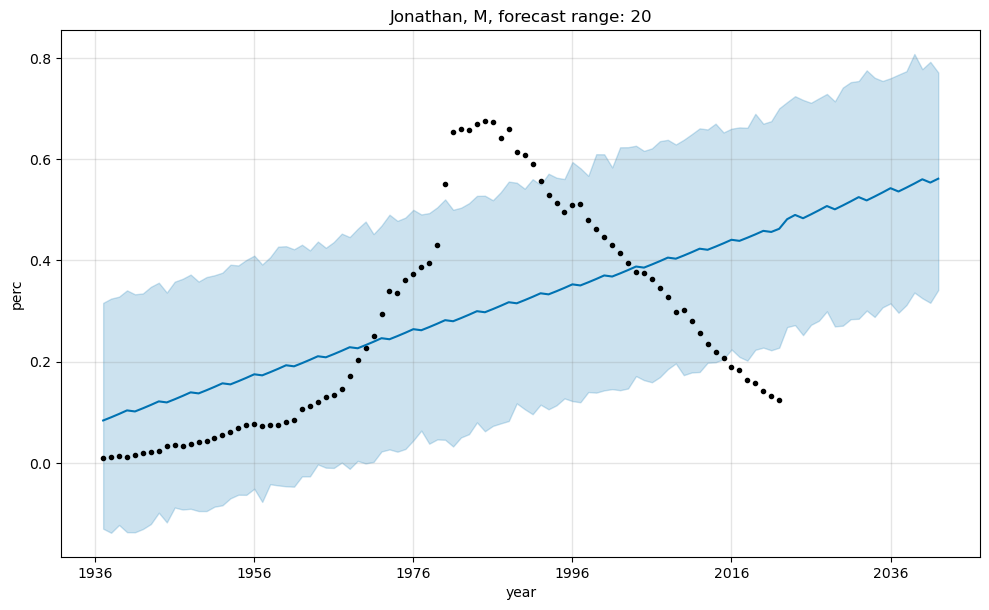

17:03:07 - cmdstanpy - INFO - Chain [1] start processing
17:03:07 - cmdstanpy - INFO - Chain [1] done processing


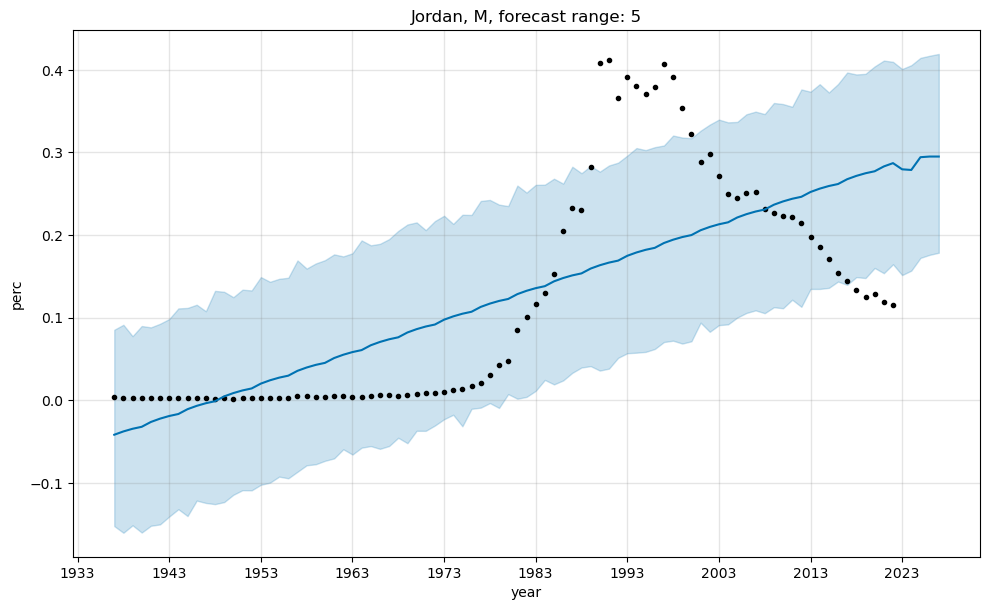

17:03:07 - cmdstanpy - INFO - Chain [1] start processing
17:03:07 - cmdstanpy - INFO - Chain [1] done processing


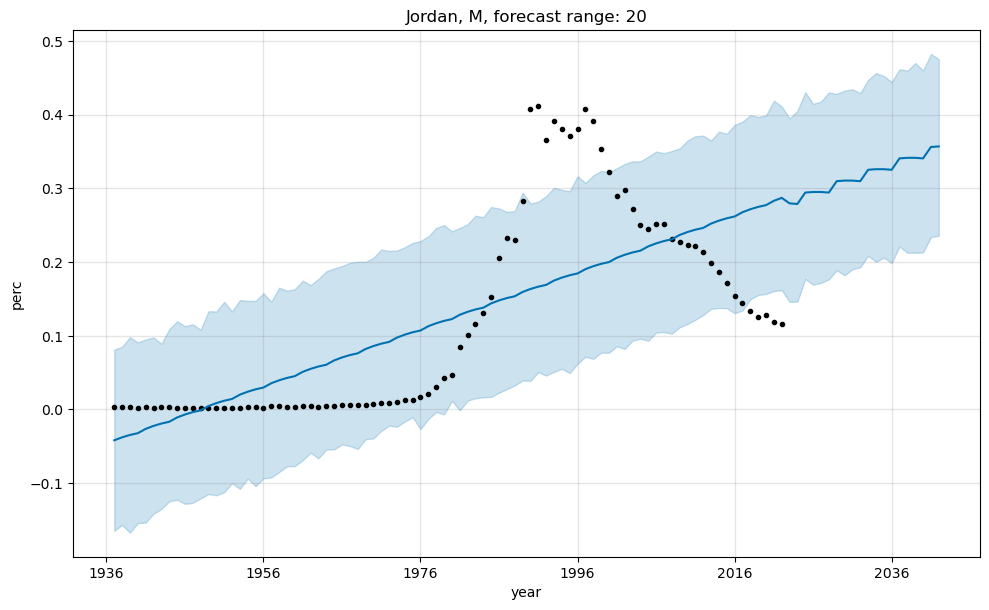

17:03:07 - cmdstanpy - INFO - Chain [1] start processing
17:03:08 - cmdstanpy - INFO - Chain [1] done processing


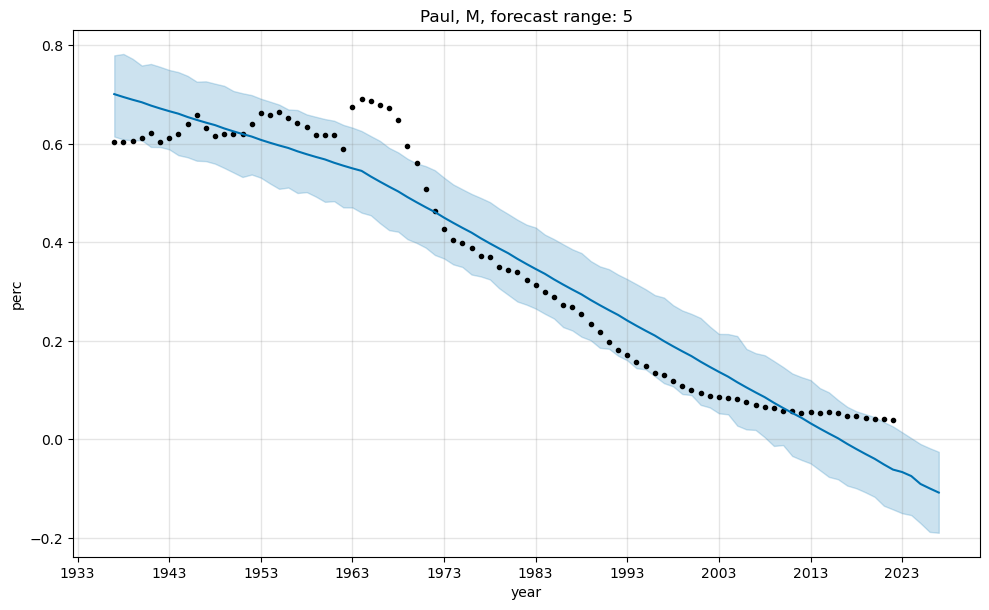

17:03:08 - cmdstanpy - INFO - Chain [1] start processing
17:03:08 - cmdstanpy - INFO - Chain [1] done processing


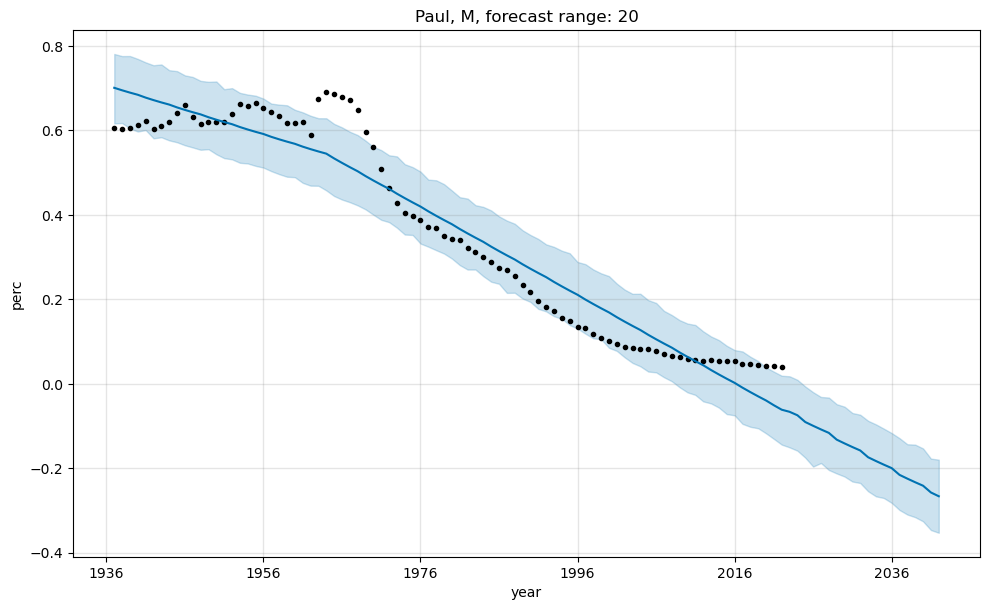

In [38]:
df_forecast = pd.DataFrame()
for (name, g) in names:
    for forecast_range in forecast_ranges:
        df = df_US_continuous[(df_US_continuous['name']==name) & (df_US_continuous['M/F']==g)]
        df = df[['ds', 'perc']].rename(columns={'perc': 'y'})
        model = Prophet()
        model.fit(df)
        future = model.make_future_dataframe(periods=forecast_range, freq='Y')  # Adjust the number of future years as needed
        forecast = model.predict(future)
        forecast['name'] = name
        # forecast['state'] = state
        forecast['M/F'] = g
        df_forecast = pd.concat([df_forecast, forecast[['ds', 'yhat', 'name', 'M/F']]])
        
        # show plot
        fig = model.plot(forecast)
        ax = fig.gca()
        ax.set_title(name + ', ' + g + ", forecast range: " + str(forecast_range))
        ax.set_xlabel("year")
        ax.set_ylabel("perc")
        plt.show()        
        plt.show()
        
        

In [ ]:
df_forecast.tail(10)